# Import Modules and init Formatting Funtions

In [1]:
import pandas as pd

import random

import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import torch
from transformers import pipeline

def build_confusion_df(y_true, y_predicted, model_name):
    confusion_df = pd.DataFrame({"y_true": y_true, f"y_{model_name}": y_predicted}).groupby(["y_true", f"y_{model_name}"]).size().unstack()
    
    confusion_df = confusion_df.T # transpose to normalize values
    for label, count in dict(pd.DataFrame(y_true)[0].value_counts()).items():
        confusion_df[label] = confusion_df[label] / count
    
    return confusion_df.T # transpose back

def draw_confusion_matrix(y_true, y_predicted, model_name):
    ax = sns.heatmap(build_confusion_df(y_true, y_predicted, model_name), cmap="Blues", annot=True, annot_kws={"fontsize":12}, fmt=".2f", vmin=0, vmax=1)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
    ax.set_xlabel(model_name, fontsize=14)
    ax.set_ylabel("manual", fontsize=14)
    
    return ax

# Init Global Vars

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # use GPU if possible
print("DEVICE IS", DEVICE)

LABELS = ["Beruf", "Herkunft", "Kompositionelles Motiv", "Rufname", "Rufnamenmuster", "Wohnstätte", "Übername"]

DEVICE IS cpu


# Load Data

In [3]:
data_path = "../data/fine-tuning/"
test_df = pd.read_csv(data_path + "dfd-motives_test.tsv", sep="\t")
test_df

,text,label
0,Scheinemann,Beruf
1,Baytekin,Kompositionelles Motiv
2,Akkus,Rufnamenmuster
3,Olejarczyk,Beruf
4,Ayaydin,Kompositionelles Motiv
...,...,...
555,Celikkol,Kompositionelles Motiv
556,Kubitscheck,Rufname
557,Metag,Rufname
558,Pühlhofer,Herkunft


In [4]:
y_true = list(test_df["label"])
y_true

['Beruf',
 'Kompositionelles Motiv',
 'Rufnamenmuster',
 'Beruf',
 'Kompositionelles Motiv',
 'Wohnstätte',
 'Rufnamenmuster',
 'Wohnstätte',
 'Rufname',
 'Beruf',
 'Rufnamenmuster',
 'Beruf',
 'Wohnstätte',
 'Rufname',
 'Kompositionelles Motiv',
 'Rufname',
 'Kompositionelles Motiv',
 'Rufname',
 'Übername',
 'Rufnamenmuster',
 'Herkunft',
 'Wohnstätte',
 'Beruf',
 'Beruf',
 'Herkunft',
 'Beruf',
 'Wohnstätte',
 'Kompositionelles Motiv',
 'Kompositionelles Motiv',
 'Rufname',
 'Herkunft',
 'Wohnstätte',
 'Herkunft',
 'Beruf',
 'Wohnstätte',
 'Rufnamenmuster',
 'Wohnstätte',
 'Rufnamenmuster',
 'Rufnamenmuster',
 'Kompositionelles Motiv',
 'Rufname',
 'Kompositionelles Motiv',
 'Rufname',
 'Rufname',
 'Rufname',
 'Übername',
 'Kompositionelles Motiv',
 'Rufnamenmuster',
 'Übername',
 'Beruf',
 'Kompositionelles Motiv',
 'Wohnstätte',
 'Herkunft',
 'Rufname',
 'Rufname',
 'Übername',
 'Rufname',
 'Rufnamenmuster',
 'Rufnamenmuster',
 'Herkunft',
 'Herkunft',
 'Wohnstätte',
 'Übername',


# Analyze with Models

## Fine-tuned GBERT

In [5]:
finetuned_gbert = pipeline("text-classification", model="../models/fine-tuned/gbert-base-dfd-motives", device=DEVICE)

In [6]:
finetuned_gbert_test_df = test_df[["text"]].copy()
finetuned_gbert_test_df["label"] = finetuned_gbert_test_df["text"].apply(lambda x: finetuned_gbert(x)[0]["label"])
finetuned_gbert_test_df

,text,label
0,Scheinemann,Beruf
1,Baytekin,Kompositionelles Motiv
2,Akkus,Rufnamenmuster
3,Olejarczyk,Beruf
4,Ayaydin,Kompositionelles Motiv
...,...,...
555,Celikkol,Rufnamenmuster
556,Kubitscheck,Rufname
557,Metag,Rufname
558,Pühlhofer,Herkunft


In [7]:
y_gbert = list(finetuned_gbert_test_df["label"])

{
    "precision": precision_score(y_true, y_gbert, average="macro", zero_division=0.0),
    "recall": recall_score(y_true, y_gbert, average="macro", zero_division=0.0),
    "f1_scores": list(f1_score(y_true, y_gbert, average=None, zero_division=0.0)),
    "f1_macro": f1_score(y_true, y_gbert, average="macro", zero_division=0.0),
    "accuracy": accuracy_score(y_true, y_gbert)  
}

{'precision': 0.8643869961248775,
 'recall': 0.8647180706589989,
 'f1_scores': [0.9156626506024096,
  0.8831168831168831,
  0.8295454545454545,
  0.9403973509933775,
  0.7701863354037267,
  0.8756756756756756,
  0.8346456692913385],
 'f1_macro': 0.8641757170898379,
 'accuracy': 0.8642857142857143}

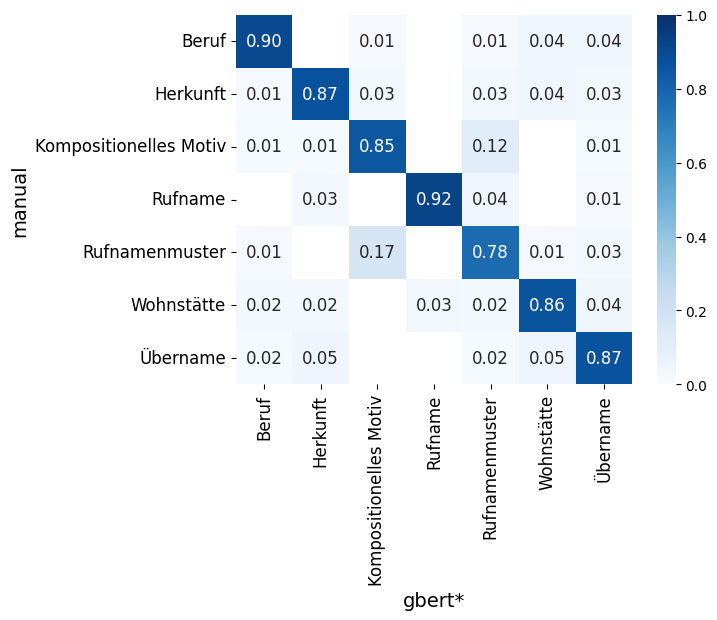

In [8]:
draw_confusion_matrix(y_true, y_gbert, "gbert*");

### Zeroshot Approach

In [9]:
mdeberta_nli = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=DEVICE)

In [10]:
mdeberta_nli_test_df = test_df[["text"]].copy()
mdeberta_nli_test_df["label"] = mdeberta_nli_test_df["text"].apply(lambda x: mdeberta_nli(x, LABELS)["labels"][0])
mdeberta_nli_test_df

,text,label
0,Scheinemann,Rufnamenmuster
1,Baytekin,Rufnamenmuster
2,Akkus,Kompositionelles Motiv
3,Olejarczyk,Rufnamenmuster
4,Ayaydin,Wohnstätte
...,...,...
555,Celikkol,Rufnamenmuster
556,Kubitscheck,Rufnamenmuster
557,Metag,Herkunft
558,Pühlhofer,Rufnamenmuster


In [11]:
y_mdeberta_nli = list(mdeberta_nli_test_df["label"])

{
    "precision": precision_score(y_true, y_mdeberta_nli, average="macro", zero_division=0.0),
    "recall": recall_score(y_true, y_mdeberta_nli, average="macro", zero_division=0.0),
    "f1_scores": list(f1_score(y_true, y_mdeberta_nli, average=None, zero_division=0.0)),
    "f1_macro": f1_score(y_true, y_mdeberta_nli, average="macro", zero_division=0.0),
    "accuracy": accuracy_score(y_true, y_mdeberta_nli)  
}

{'precision': 0.11673034734940513,
 'recall': 0.13535565120845902,
 'f1_scores': [0.2333333333333333,
  0.05217391304347826,
  0.0,
  0.0,
  0.21945137157107228,
  0.160427807486631,
  0.03921568627450981],
 'f1_macro': 0.10065744452986067,
 'accuracy': 0.1392857142857143}

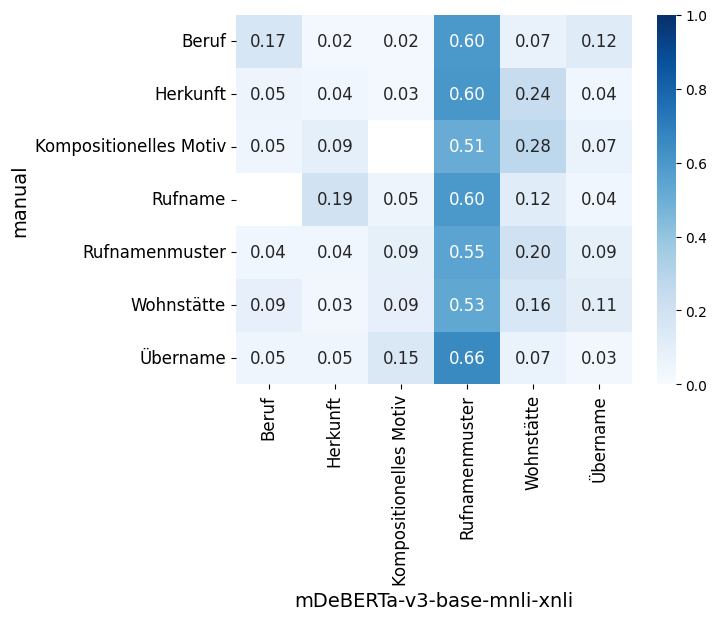

In [12]:
draw_confusion_matrix(y_true, y_mdeberta_nli, "mDeBERTa-v3-base-mnli-xnli");

# Majority Baseline

In [13]:
y_majority = ["Rufname" for i in range(len(y_true))]

{
    "precision": precision_score(y_true, y_majority, average="macro", zero_division=0.0),
    "recall": recall_score(y_true, y_majority, average="macro", zero_division=0.0),
    "f1_scores": list(f1_score(y_true, y_majority, average=None, zero_division=0.0)),
    "f1_macro": f1_score(y_true, y_majority, average="macro", zero_division=0.0),
    "accuracy": accuracy_score(y_true, y_majority)  
}

{'precision': 0.019642857142857146,
 'recall': 0.14285714285714285,
 'f1_scores': [0.0, 0.0, 0.0, 0.2417582417582418, 0.0, 0.0, 0.0],
 'f1_macro': 0.03453689167974883,
 'accuracy': 0.1375}

In [14]:
y_majority = ["Übername" for i in range(len(y_true))]

{
    "precision": precision_score(y_true, y_majority, average="macro", zero_division=0.0),
    "recall": recall_score(y_true, y_majority, average="macro", zero_division=0.0),
    "f1_scores": list(f1_score(y_true, y_majority, average=None, zero_division=0.0)),
    "f1_macro": f1_score(y_true, y_majority, average="macro", zero_division=0.0),
    "accuracy": accuracy_score(y_true, y_majority)  
}

{'precision': 0.01556122448979592,
 'recall': 0.14285714285714285,
 'f1_scores': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19645732689210949],
 'f1_macro': 0.0280653324131585,
 'accuracy': 0.10892857142857143}

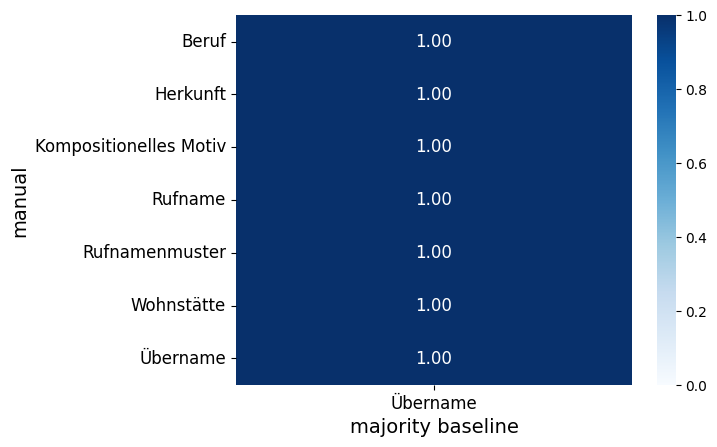

In [15]:
draw_confusion_matrix(y_true, y_majority, "majority baseline");

# Random Baseline

In [17]:
import random

random.seed(0)
y_random = random.choices(LABELS, k=len(test_df))

{
    "precision": precision_score(y_true, y_random, average="macro", zero_division=0.0),
    "recall": recall_score(y_true, y_random, average="macro", zero_division=0.0),
    "f1_scores": list(f1_score(y_true, y_random, average=None, zero_division=0.0)),
    "f1_macro": f1_score(y_true, y_random, average="macro", zero_division=0.0),
    "accuracy": accuracy_score(y_true, y_random)  
}

{'precision': 0.1710966397072992,
 'recall': 0.17276577872818807,
 'f1_scores': [0.15116279069767444,
  0.1388888888888889,
  0.20809248554913293,
  0.13513513513513514,
  0.1863354037267081,
  0.1893491124260355,
  0.18300653594771243],
 'f1_macro': 0.17028147891018391,
 'accuracy': 0.17142857142857143}

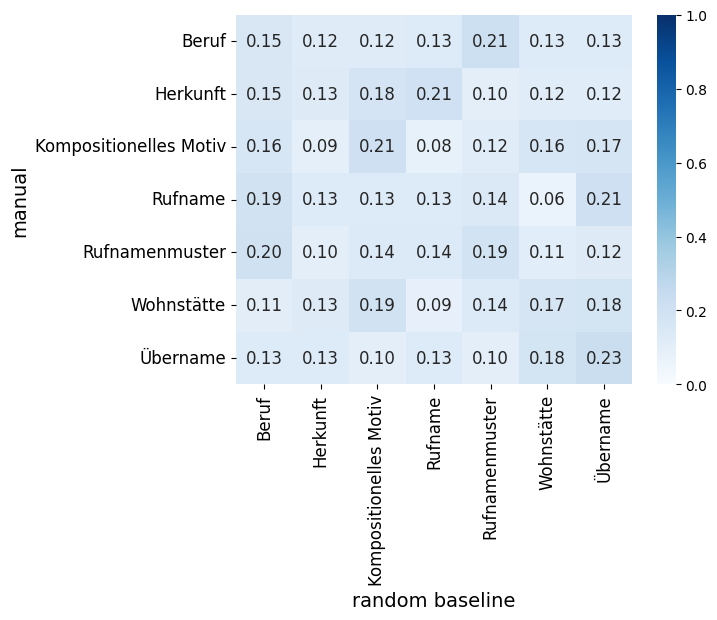

In [18]:
draw_confusion_matrix(y_true, y_random, "random baseline");